# 로그-정규분포 데이터 셋 생성
- 오전 9시부터~오후10시까지 (활동시간에 심박 분포를 가정하였기에)
- 1주일의 데이터 포인트 수: 하루에 780분, 일주일은 7일이므로:  
780분/일×7일=5,460분/주
- 1~3주의 데이터 포인트 수: 첫 3주간의 데이터는:  
5,460분/주×3주=16,380분
- 4주차의 데이터 포인트 수: 네 번째 주의 데이터는:  
5,460분/주

## 보통 심박 60-100 생성

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import matplotlib
import matplotlib.font_manager as fm
# fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = 'C:/Windows/Fonts/gulim.ttc' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [24]:
# 주어진 경계에서 벗어난 값의 비율을 계산하는 함수
def calculate_outliers_proportion(mu, sigma, lower_bound, upper_bound, size):
    samples = np.random.lognormal(mean=mu, sigma=sigma, size=size)
    proportion = np.mean((samples < lower_bound) | (samples > upper_bound))
    return proportion

# 목표 이상치 비율을 달성하기 위해 sigma 값을 조정하는 함수
def adjust_sigma_for_outliers(target_proportion, mu, sigma, lower_bound, upper_bound, size, iterations):
    for _ in range(iterations):
        proportion = calculate_outliers_proportion(mu, sigma, lower_bound, upper_bound, size)
        # 이상치 비율이 목표보다 높으면 sigma 값을 줄이고, 낮으면 늘립니다.
        if proportion > target_proportion:
            sigma *= (1 - (proportion - target_proportion))
        elif proportion < target_proportion:
            sigma *= (1 + (target_proportion - proportion))
    return sigma

# 이상치의 목표 비율 설정
target_proportion_outliers = 0.05  # 데이터의 5%를 이상치로 설정

# 로그정규분포의 초기 매개변수 설정
mu_init = np.log(80)  # 로그정규분포의 평균 로그값 설정 (중간값이 80이 되도록)
sigma_init = 0.1  # 로그정규분포의 표준편차 초기 추정치

# 목표 이상치 비율을 기반으로 sigma 값을 조정
adjusted_sigma = adjust_sigma_for_outliers(
    target_proportion_outliers,  # 목표 이상치 비율
    mu_init,  # 초기 mu 값
    sigma_init,  # 초기 sigma 값
    60,  # 이상치 하한값
    100, # 이상치 상한값
    24180, # 샘플 크기
    10  # 반복 횟수
)

# 조정된 sigma 값으로 최종 이상치 비율 확인
final_proportion_outliers = calculate_outliers_proportion(
    mu_init,
    adjusted_sigma,
    60,
    100,
    24180
)

# 출력: 초기 mu, 조정된 sigma, 최종 이상치 비율
print("초기 mu:", mu_init)
print("조정된 sigma:", adjusted_sigma)
print("최종 이상치 비율:", final_proportion_outliers)

# 추정된 최종 mu와 sigma
final_mu = mu_init
final_sigma = adjusted_sigma
print("최종 mu (로그 스케일):", final_mu)
print("최종 sigma:", final_sigma)


초기 mu: 4.382026634673881
조정된 sigma: 0.1223928964649548
최종 이상치 비율: 0.04098428453267163
최종 mu (로그 스케일): 4.382026634673881
최종 sigma: 0.1223928964649548


In [388]:
# 활동 시간에 해당하는 시간 범위를 생성하는 함수
def create_active_time_range(start_date, end_date, start_hour, end_hour):
    # 모든 날짜에 대한 시간 범위 생성
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    time_list = []
    
    # 각 날짜에 대해 활동 시간 범위 생성
    for single_date in all_dates:
        daily_time_range = pd.date_range(start=single_date + pd.DateOffset(hours=start_hour),
                                         end=single_date + pd.DateOffset(hours=end_hour, minutes=-1),
                                         freq='T')
        time_list.extend(daily_time_range)
    
    return time_list

# Generate the active time range
active_time_range = create_active_time_range('2024-01-01', '2024-01-31', 9, 22)

# Create the DataFrame
df = pd.DataFrame()

# 최종 추정된 매개변수 사용
final_mu = 4.382026634673881
final_sigma = 0.125

# 각 변수 생성 및 데이터프레임 병합
for i in range(1, 101):
    # 각 변수별로 다른 random seed 설정
    np.random.seed(i)
    
    # 로그정규분포에서 데이터 추출 (이상치 비율을 조정한 매개변수 사용)
    r_data = np.random.lognormal(final_mu, final_sigma, 24180)
    
    # 변수명 생성
    var_name = f'heart_rate{i}'
    
    # 데이터프레임에 변수 추가
    df[var_name] = r_data
    
    # event 변수 생성 (이상치 정의: 60미만 또는 100초과)
    df[f'event{i}'] = df[var_name].apply(lambda x: 1 if (x < 60) or (x > 100) else 0)
    
    # 변수 별로 데이터 순서를 무작위로 섞기
    df = df.sample(frac=1, random_state=i)

# Insert the active time range as the first column of the DataFrame
if len(active_time_range) > len(df):
    active_time_range = active_time_range[:len(df)]
elif len(active_time_range) < len(df):
    raise ValueError("Not enough time points. Consider extending the end_date.")

df.insert(0, 'time', active_time_range)

# 데이터프레임의 크기 출력
df.reset_index(drop=True, inplace=True)
print(df.shape)

# 첫 번째 event 변수에 대해 이상치 비율 계산 및 출력
outlier_proportion = df['event1'].mean()
print(f"Proportion of outliers in 'event1': {outlier_proportion:.4f}")
print(f"Proportion of outliers in 'event1': {outlier_proportion*100:.2f}%")
print(len(df[df['event1'] == 1])/len(df))

(24180, 201)
Proportion of outliers in 'event1': 0.0481
Proportion of outliers in 'event1': 4.81%
0.048056244830438376


In [389]:
print(df.head(2));df.tail(2)

                 time  heart_rate1  event1  heart_rate2  event2  heart_rate3  \
0 2024-01-01 09:00:00    85.689072       0    83.619243       0   100.388465   
1 2024-01-01 09:01:00    70.799472       0    80.284777       0    79.134970   

   event3  heart_rate4  event4  heart_rate5  ...  heart_rate96  event96  \
0       1    68.436331       0    89.053103  ...     79.909588        0   
1       0    86.997365       0    89.120294  ...     81.876244        0   

   heart_rate97  event97  heart_rate98  event98  heart_rate99  event99  \
0     78.703384        0     74.131167        0     85.103926        0   
1     70.098775        0     77.329517        0     80.226264        0   

   heart_rate100  event100  
0     104.703351         1  
1      60.309250         0  

[2 rows x 201 columns]


,time,heart_rate1,event1,heart_rate2,event2,heart_rate3,event3,heart_rate4,event4,heart_rate5,...,heart_rate96,event96,heart_rate97,event97,heart_rate98,event98,heart_rate99,event99,heart_rate100,event100
24178,2024-01-31 21:58:00,104.569955,1,80.446256,0,93.029047,0,71.823957,0,75.326837,...,78.693057,0,96.980463,0,82.227275,0,88.028712,0,69.053217,0
24179,2024-01-31 21:59:00,85.894227,0,84.284811,0,80.688591,0,71.735323,0,62.583471,...,76.362338,0,81.365802,0,71.549340,0,79.663147,0,92.420572,0


### 보통 심박 그래프 표시

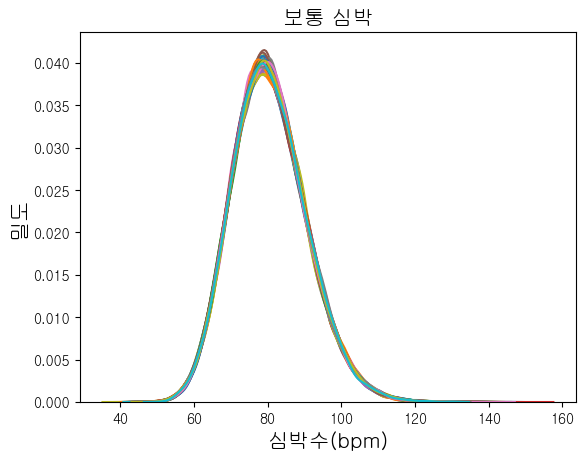

In [405]:
import seaborn as sns
for i in range(1,101):
    sns.kdeplot(df[f'heart_rate{i}'])

plt.title('보통 심박', fontsize=15)
plt.xlabel('심박수(bpm)', fontsize=15)
plt.ylabel('밀도', fontsize=15)
plt.savefig('보통심박수분포.png', dpi=300)

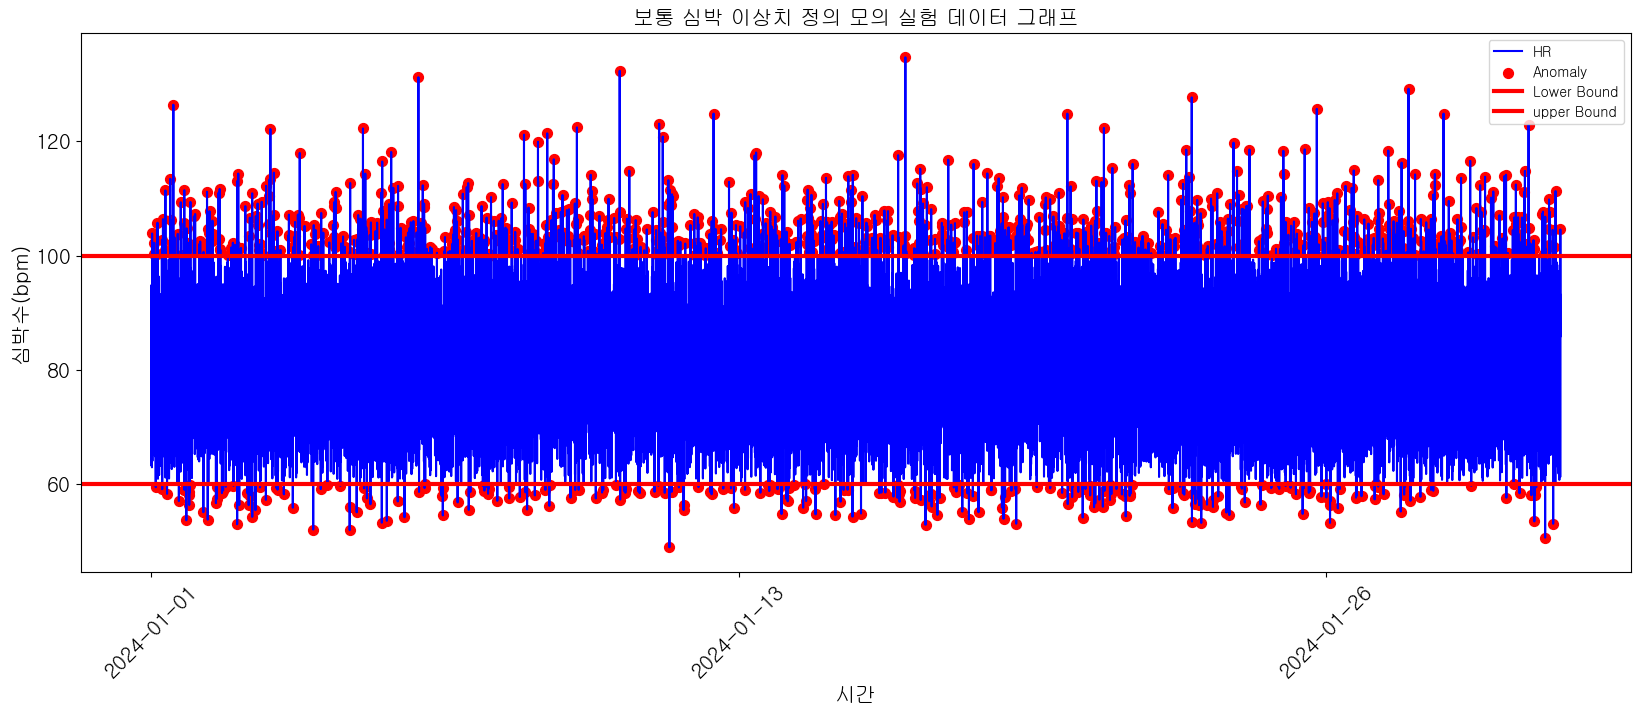

In [415]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(df)), df['heart_rate1'], label='HR', color='blue')

time_labels = df['time'][::7*24*60]  # 7일, 24시간, 60분
anomalies = df[df['event1'] == 1]
plt.scatter(np.arange(len(df))[df['event1'] == 1], anomalies['heart_rate1'],
             color='red', label='Anomaly', s=50)

plt.title('Total Anomalies')
plt.xlabel('Time')
import matplotlib.pyplot as plt

plt.axhline(y=60, color='red', label='Lower Bound', linewidth=3)
plt.axhline(y=100, color='red', label='upper Bound', linewidth=3)
plt.xticks(fontsize=15)
plt.xlabel('시간', fontsize=15, fontweight='bold')
plt.xticks(ticks=time_labels.index, labels=time_labels.dt.strftime('%Y-%m-%d'), rotation=45, fontsize=15)
plt.ylabel('심박수(bpm)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15)
plt.title('보통 심박 이상치 정의 모의 실험 데이터 그래프', fontsize=15, fontweight='bold')
plt.legend()
plt.savefig('../result/보통심박 이상치 그래프.png', dpi=300)

In [392]:
df.to_csv('../data/로그정규/보통심박.csv', index=False, encoding='cp949')

## 운동 상태 심박

### 2030
- 94 ~ 159.5, 79.4
- max:188

In [416]:
print((162+157)/2)

159.5


In [319]:
np.log(105)

4.653960350157523

In [417]:
import numpy as np
import pandas as pd

# 전체 데이터 크기 설정
data_size = 24180  # 이상치를 포함한 총 데이터 크기

# 상한값과 하한값 이상치의 수 설정
lower_outlier_count = 241
upper_outlier_count = 967

# 로그 정규분포 매개변수 설정
final_mu = np.log(105)
final_sigma = 0.1

# 데이터프레임 생성
df_heart_rate = pd.DataFrame()
df_event = pd.DataFrame()

# 각 변수 생성 및 데이터프레임 병합
for i in range(1, 101):
    # 각 변수별로 다른 random seed 설정
    np.random.seed(i)
    
    # 로그정규분포에서 데이터 추출
    r_data = np.random.lognormal(final_mu, final_sigma, data_size - lower_outlier_count - upper_outlier_count)
    
    # 이상치 생성
    lower_outliers = np.random.uniform(low=50, high=75, size=lower_outlier_count)
    upper_outliers = np.random.uniform(low=160, high=188, size=upper_outlier_count)
    
    # 정규 데이터와 이상치 결합
    all_data = np.concatenate([r_data, lower_outliers, upper_outliers])
    np.random.shuffle(all_data)  # 데이터 섞기
    
    # 데이터프레임에 변수 추가
    df_heart_rate[f'heart_rate{i}'] = all_data
    
    # 이상치 식별
    df_event[f'event{i}'] = np.where((all_data < 79.4) | (all_data > 160), 1, 0)

# 시간 범위 생성
active_time_range = pd.date_range(start='2024-01-01 09:00', end='2024-01-31 22:00', freq='T')
# 데이터 길이 조정
active_time_range = active_time_range[:data_size]

# 시간 열 추가
df_2030 = pd.DataFrame(active_time_range, columns=['time'])

# 데이터프레임 병합
df_2030 = pd.concat([df_2030, df_heart_rate, df_event], axis=1)

# 데이터프레임의 크기와 이상치 비율 확인
print(df_2030.shape)
outlier_proportion = df_event.mean(axis=0)
print(f"Average proportion of outliers across all variables: {outlier_proportion.mean():.2%}")
print(f"Proportion of outliers: {len(df_2030[df_2030['event1']==1])/len(df_2030)}")
print(f"Proportion of lower_outliers: {len(df_2030[(df_2030['heart_rate1'] < 79.4) & (df_2030['heart_rate1'] >= 0)])/len(df_2030):.2%}")
print(f"Proportion of upper outliers: {len(df_2030[(df_2030['heart_rate1'] > 160)])/len(df_2030):.2%}")


(24180, 201)
Average proportion of outliers across all variables: 5.25%
Proportion of outliers: 0.052274607113316794
Proportion of lower_outliers: 1.23%
Proportion of upper outliers: 4.00%


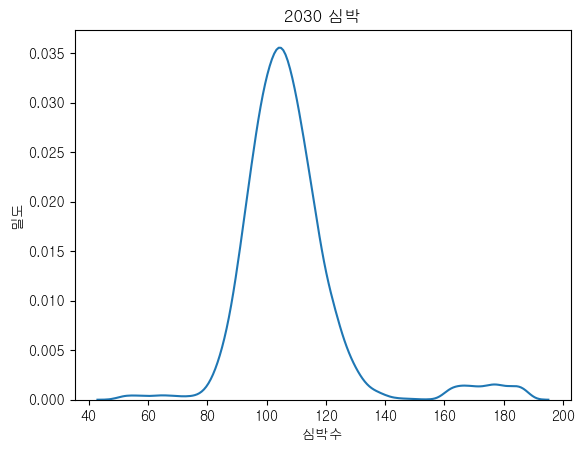

In [418]:
sns.kdeplot(df_2030[f'heart_rate1'])

plt.title('2030 심박')
plt.xlabel('심박수')
plt.ylabel('밀도')
plt.show()

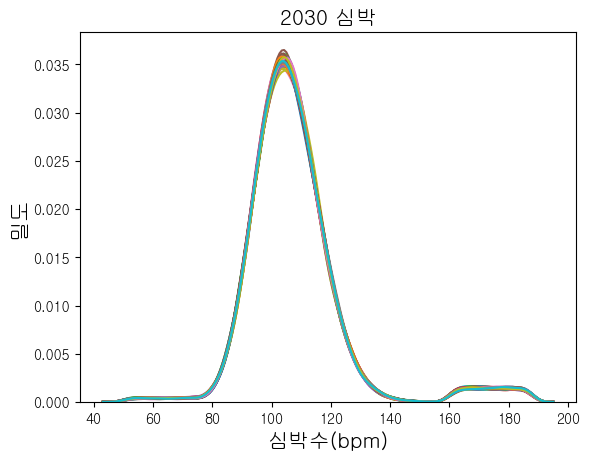

In [424]:
import seaborn as sns
for i in range(1,101):
    sns.kdeplot(df_2030[f'heart_rate{i}'])

plt.title('2030 심박', fontsize=15, fontweight='bold')
plt.xlabel('심박수(bpm)', fontsize=15, fontweight='bold')
plt.ylabel('밀도', fontsize=15, fontweight='bold')
plt.savefig('../result/심박수분포2030.png', dpi=300)

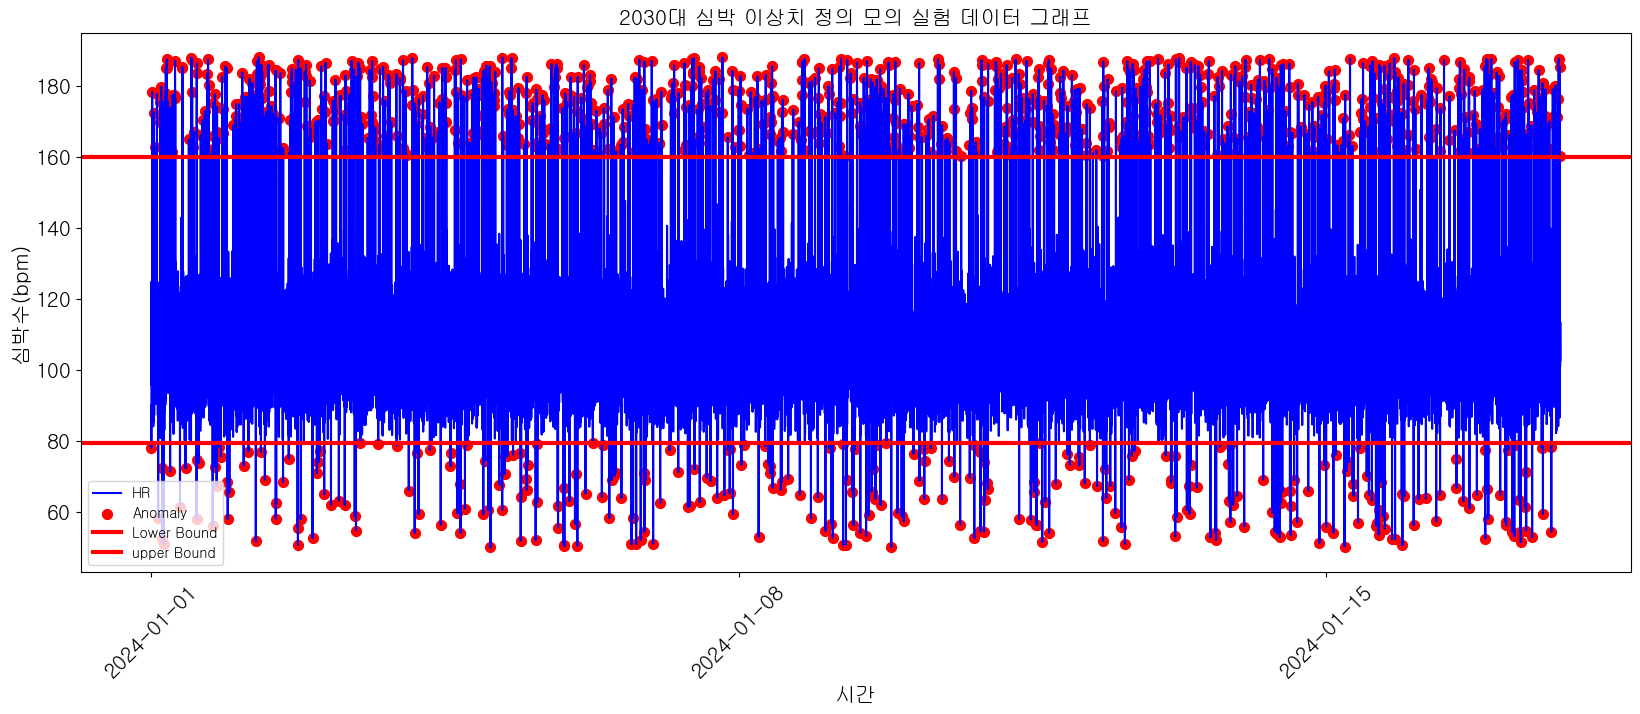

In [426]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(df_2030)), df_2030['heart_rate1'], label='HR', color='blue')

time_labels = df_2030['time'][::7*24*60]  # 7일, 24시간, 60분
anomalies = df_2030[df_2030['event1'] == 1]
plt.scatter(np.arange(len(df_2030))[df_2030['event1'] == 1], anomalies['heart_rate1'],
             color='red', label='Anomaly', s=50)

plt.title('Total Anomalies')
plt.xlabel('Time')
import matplotlib.pyplot as plt

plt.axhline(y=79.4, color='red', label='Lower Bound', linewidth=3)
plt.axhline(y=160, color='red', label='upper Bound', linewidth=3)
plt.xticks(fontsize=15)
plt.xlabel('시간', fontsize=15, fontweight='bold')
plt.xticks(ticks=time_labels.index, labels=time_labels.dt.strftime('%Y-%m-%d'), rotation=45, fontsize=15)
plt.ylabel('심박수(bpm)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15)
plt.title('2030대 심박 이상치 정의 모의 실험 데이터 그래프', fontsize=15, fontweight='bold')
plt.legend()
plt.savefig('../result/심박 2030대 이상치 그래프.png', dpi=300)



In [371]:
df_2030.to_csv('../data/로그정규/심박_2030.csv', index=False, encoding='cp949')

### 4050
- 87~147, 77
- max: 177

In [372]:
(78.5+75.3)/2

76.9

2
8
8.706630098820251e-05
0.00034826520395281004


<Axes: ylabel='Density'>

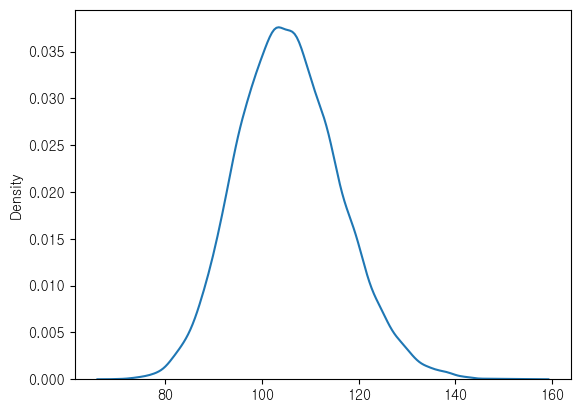

In [373]:
final_mu = np.log(105)
final_sigma = 0.1

aa = np.random.lognormal(final_mu, final_sigma, 22971)

print(aa[aa<72].shape[0])
print(aa[aa>147].shape[0])
print(len(aa[aa<72])/len(aa))
print(len(aa[aa>147])/len(aa))
sns.kdeplot(aa)   

In [374]:
import numpy as np
import pandas as pd

# 전체 데이터 크기 설정
data_size = 24180  # 이상치를 포함한 총 데이터 크기

# 상한값과 하한값 이상치의 수 설정
lower_outlier_count = 241
upper_outlier_count = 967

# 로그 정규분포 매개변수 설정
final_mu = np.log(105)
final_sigma = 0.1

# 데이터프레임 생성
df_heart_rate = pd.DataFrame()
df_event = pd.DataFrame()

# 각 변수 생성 및 데이터프레임 병합
for i in range(1, 101):
    # 각 변수별로 다른 random seed 설정
    np.random.seed(i)
    
    # 로그정규분포에서 데이터 추출
    r_data = np.random.lognormal(final_mu, final_sigma, data_size - lower_outlier_count - upper_outlier_count)
    
    # 이상치 생성
    lower_outliers = np.random.randint(low=50, high=70, size=lower_outlier_count)
    upper_outliers = np.random.randint(low=147, high=177, size=upper_outlier_count)
    
    # 정규 데이터와 이상치 결합
    all_data = np.concatenate([r_data, lower_outliers, upper_outliers])
    np.random.shuffle(all_data)  # 데이터 섞기
    
    # 데이터프레임에 변수 추가
    df_heart_rate[f'heart_rate{i}'] = all_data
    
    # 이상치 식별
    df_event[f'event{i}'] = np.where((all_data < 76.9) | (all_data > 147), 1, 0)

# 시간 범위 생성
active_time_range = pd.date_range(start='2024-01-01 09:00', end='2024-01-31 22:00', freq='T')
# 데이터 길이 조정
active_time_range = active_time_range[:data_size]

# 시간 열 추가
df_4050 = pd.DataFrame(active_time_range, columns=['time'])

# 데이터프레임 병합
df_4050 = pd.concat([df_4050, df_heart_rate, df_event], axis=1)

# 데이터프레임의 크기와 이상치 비율 확인
print(df_4050.shape)
outlier_proportion = df_event.mean(axis=0)
print(f"Average proportion of outliers across all variables: {outlier_proportion.mean():.2%}")
print(f"Proportion of outliers: {len(df_4050[df_4050['event1']==1])/len(df_4050)}")
print(f"Proportion of lower_outliers: {len(df_4050[(df_4050['heart_rate1'] < 76.9) & (df_4050['heart_rate1'] >= 0)])/len(df_4050):.2%}")
print(f"Proportion of upper outliers: {len(df_4050[(df_4050['heart_rate1'] > 147)])/len(df_4050):.2%}")


(24180, 201)
Average proportion of outliers across all variables: 4.98%
Proportion of outliers: 0.05028949545078577
Proportion of lower_outliers: 1.08%
Proportion of upper outliers: 3.95%


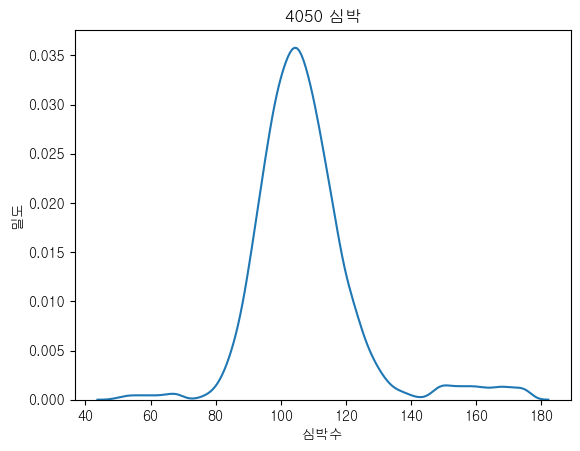

In [420]:
sns.kdeplot(df_4050[f'heart_rate1'])

plt.title('4050 심박')
plt.xlabel('심박수')
plt.ylabel('밀도')
plt.show()

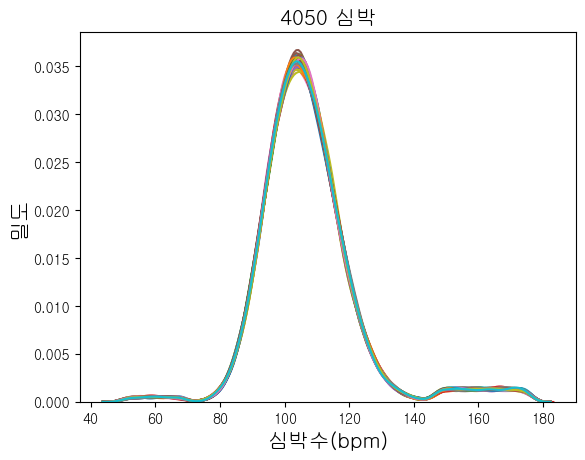

In [425]:
import seaborn as sns
for i in range(1,101):
    sns.kdeplot(df_4050[f'heart_rate{i}'])

plt.title('4050 심박', fontsize=15, fontweight='bold')
plt.xlabel('심박수(bpm)', fontsize=15, fontweight='bold')
plt.ylabel('밀도', fontsize=15, fontweight='bold')
plt.savefig('../result/심박수분포4050.png', dpi=300)

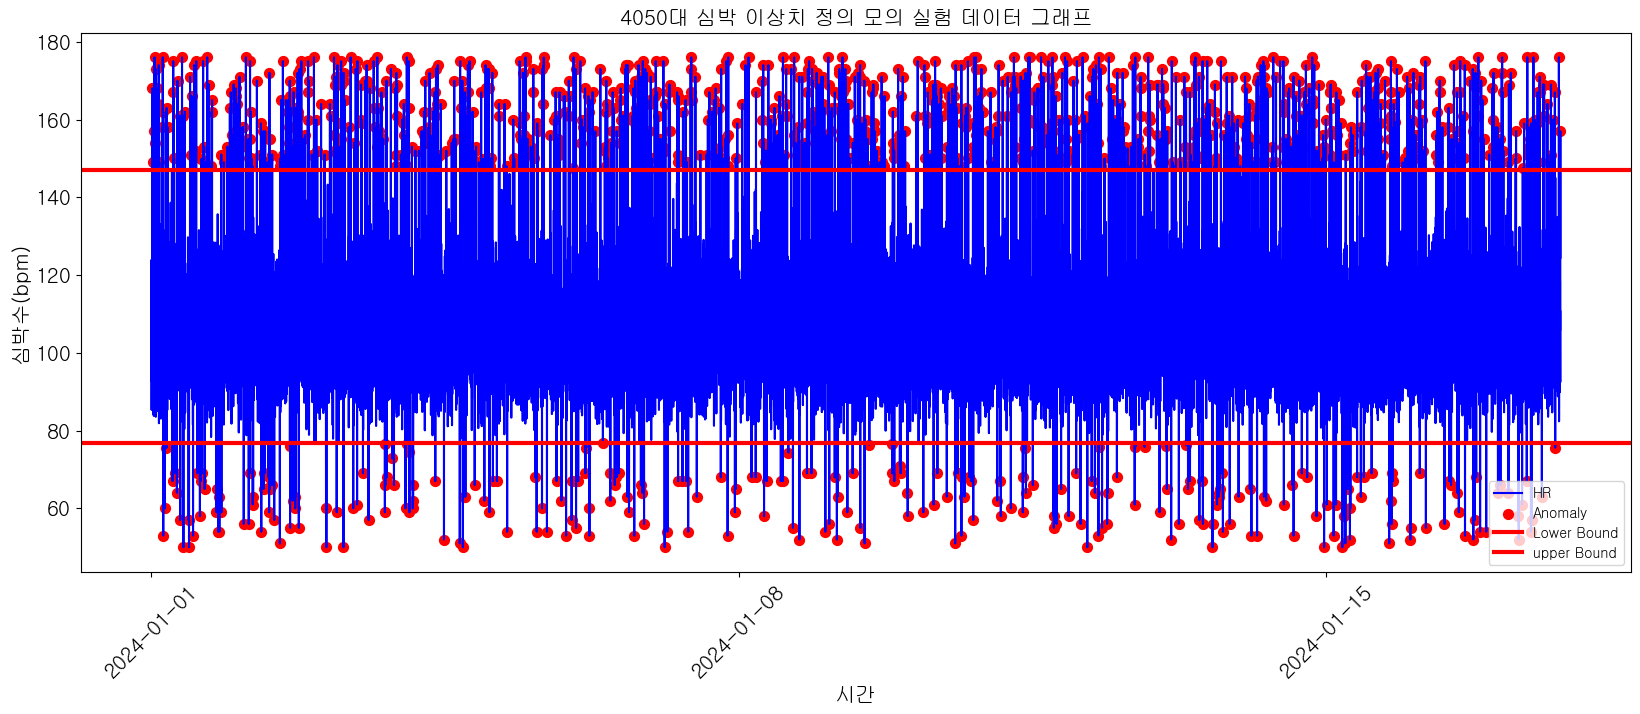

In [427]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(df_4050)), df_4050['heart_rate1'], label='HR', color='blue')

time_labels = df_4050['time'][::7*24*60]  # 7일, 24시간, 60분
anomalies = df_4050[df_4050['event1'] == 1]
plt.scatter(np.arange(len(df_4050))[df_4050['event1'] == 1], anomalies['heart_rate1'],
             color='red', label='Anomaly', s=50)

plt.title('Total Anomalies')
plt.xlabel('Time')
import matplotlib.pyplot as plt

plt.axhline(y=76.9, color='red', label='Lower Bound', linewidth=3)
plt.axhline(y=147, color='red', label='upper Bound', linewidth=3)
plt.xticks(fontsize=15)
plt.xlabel('시간', fontsize=15, fontweight='bold')
plt.xticks(ticks=time_labels.index, labels=time_labels.dt.strftime('%Y-%m-%d'), rotation=45, fontsize=15)
plt.ylabel('심박수(bpm)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15)
plt.title('4050대 심박 이상치 정의 모의 실험 데이터 그래프', fontsize=15, fontweight='bold')
plt.legend()
plt.savefig('../result/심박 4050대 이상치 그래프.png', dpi=300)

In [395]:
df_4050.head()

,time,heart_rate1,heart_rate2,heart_rate3,heart_rate4,heart_rate5,heart_rate6,heart_rate7,heart_rate8,heart_rate9,...,event91,event92,event93,event94,event95,event96,event97,event98,event99,event100
0,2024-01-01 09:00:00,97.496679,95.672346,100.678662,53.000000,105.679373,130.682394,88.561378,95.356306,106.860179,...,0,0,0,0,0,0,0,0,0,0
1,2024-01-01 09:01:00,123.889031,104.990027,95.802568,112.202551,108.467463,100.182643,107.510929,109.943174,106.137830,...,0,0,0,0,0,0,0,0,0,0
2,2024-01-01 09:02:00,92.797679,102.315435,117.042325,100.426224,167.000000,118.825076,112.011045,104.740314,104.112336,...,0,0,0,0,1,0,0,1,0,0
3,2024-01-01 09:03:00,108.247649,97.227464,88.855299,83.160290,113.293689,94.469131,101.635784,86.423819,94.174508,...,0,0,0,0,0,0,0,0,0,0
4,2024-01-01 09:04:00,108.564248,84.484594,98.753728,107.894950,110.441946,100.519210,124.745097,102.737285,109.245399,...,0,0,0,0,0,0,0,0,0,0


In [378]:
df_4050.to_csv('../data/로그정규/심박_4050.csv', index=False, encoding='cp949')

### 6070
- 77~130,73.5
- max: 153

In [379]:
(73.9+73)/2

73.45

0
2
0.0
8.706630098820251e-05


<Axes: ylabel='Density'>

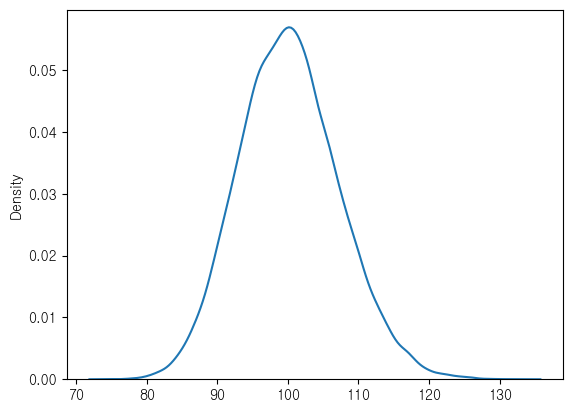

In [380]:
final_mu = np.log(100)
final_sigma = 0.07

aa = np.random.lognormal(final_mu, final_sigma, 22971)

print(aa[aa<73.5].shape[0])
print(aa[aa>130].shape[0])
print(len(aa[aa<73.5])/len(aa))
print(len(aa[aa>130])/len(aa))
sns.kdeplot(aa)   

In [381]:
import numpy as np
import pandas as pd

# 전체 데이터 크기 설정
data_size = 24180  # 이상치를 포함한 총 데이터 크기

# 상한값과 하한값 이상치의 수 설정
lower_outlier_count = 241
upper_outlier_count = 967

# 로그 정규분포 매개변수 설정
final_mu = np.log(100)
final_sigma = 0.07

# 데이터프레임 생성
df_heart_rate = pd.DataFrame()
df_event = pd.DataFrame()

# 각 변수 생성 및 데이터프레임 병합
for i in range(1, 101):
    # 각 변수별로 다른 random seed 설정
    np.random.seed(i)
    
    # 로그정규분포에서 데이터 추출
    r_data = np.random.lognormal(final_mu, final_sigma, data_size - lower_outlier_count - upper_outlier_count)
    
    # 이상치 생성
    lower_outliers = np.random.randint(low=50, high=70, size=lower_outlier_count)
    upper_outliers = np.random.randint(low=130, high=153, size=upper_outlier_count)
    
    # 정규 데이터와 이상치 결합
    all_data = np.concatenate([r_data, lower_outliers, upper_outliers])
    np.random.shuffle(all_data)  # 데이터 섞기
    
    # 데이터프레임에 변수 추가
    df_heart_rate[f'heart_rate{i}'] = all_data
    
    # 이상치 식별
    df_event[f'event{i}'] = np.where((all_data < 73.5) | (all_data > 130), 1, 0)

# 시간 범위 생성
active_time_range = pd.date_range(start='2024-01-01 09:00', end='2024-01-31 22:00', freq='T')
# 데이터 길이 조정
active_time_range = active_time_range[:data_size]

# 시간 열 추가
df_6070 = pd.DataFrame(active_time_range, columns=['time'])

# 데이터프레임 병합
df_6070 = pd.concat([df_6070, df_heart_rate, df_event], axis=1)

# 데이터프레임의 크기와 이상치 비율 확인
print(df_6070.shape)
outlier_proportion = df_event.mean(axis=0)
print(f"Average proportion of outliers across all variables: {outlier_proportion.mean():.2%}")
print(f"Proportion of outliers: {len(df_6070[df_6070['event1']==1])/len(df_6070)}")
print(f"Proportion of lower_outliers: {len(df_6070[(df_6070['heart_rate1'] < 73.5) & (df_6070['heart_rate1'] >= 0)])/len(df_6070):.2%}")
print(f"Proportion of upper outliers: {len(df_6070[(df_6070['heart_rate1'] > 130)])/len(df_6070):.2%}")


(24180, 201)
Average proportion of outliers across all variables: 4.83%
Proportion of outliers: 0.048552522746071136
Proportion of lower_outliers: 1.00%
Proportion of upper outliers: 3.86%


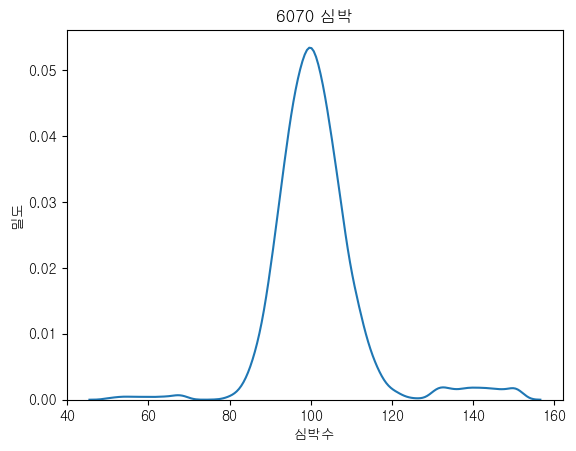

In [422]:
sns.kdeplot(df_6070[f'heart_rate1'])

plt.title('6070 심박')
plt.xlabel('심박수')
plt.ylabel('밀도')
plt.show()

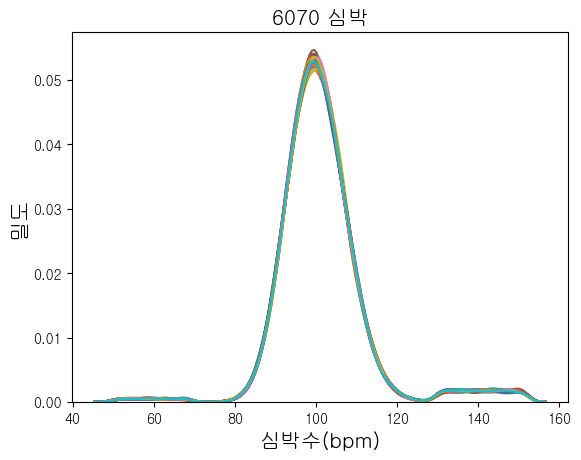

In [423]:
import seaborn as sns
for i in range(1,101):
    sns.kdeplot(df_6070[f'heart_rate{i}'])

plt.title('6070 심박', fontsize=15, fontweight='bold')
plt.xlabel('심박수(bpm)', fontsize=15, fontweight='bold')
plt.ylabel('밀도', fontsize=15, fontweight='bold')
plt.savefig('../result/심박수분포6070.png', dpi=300)

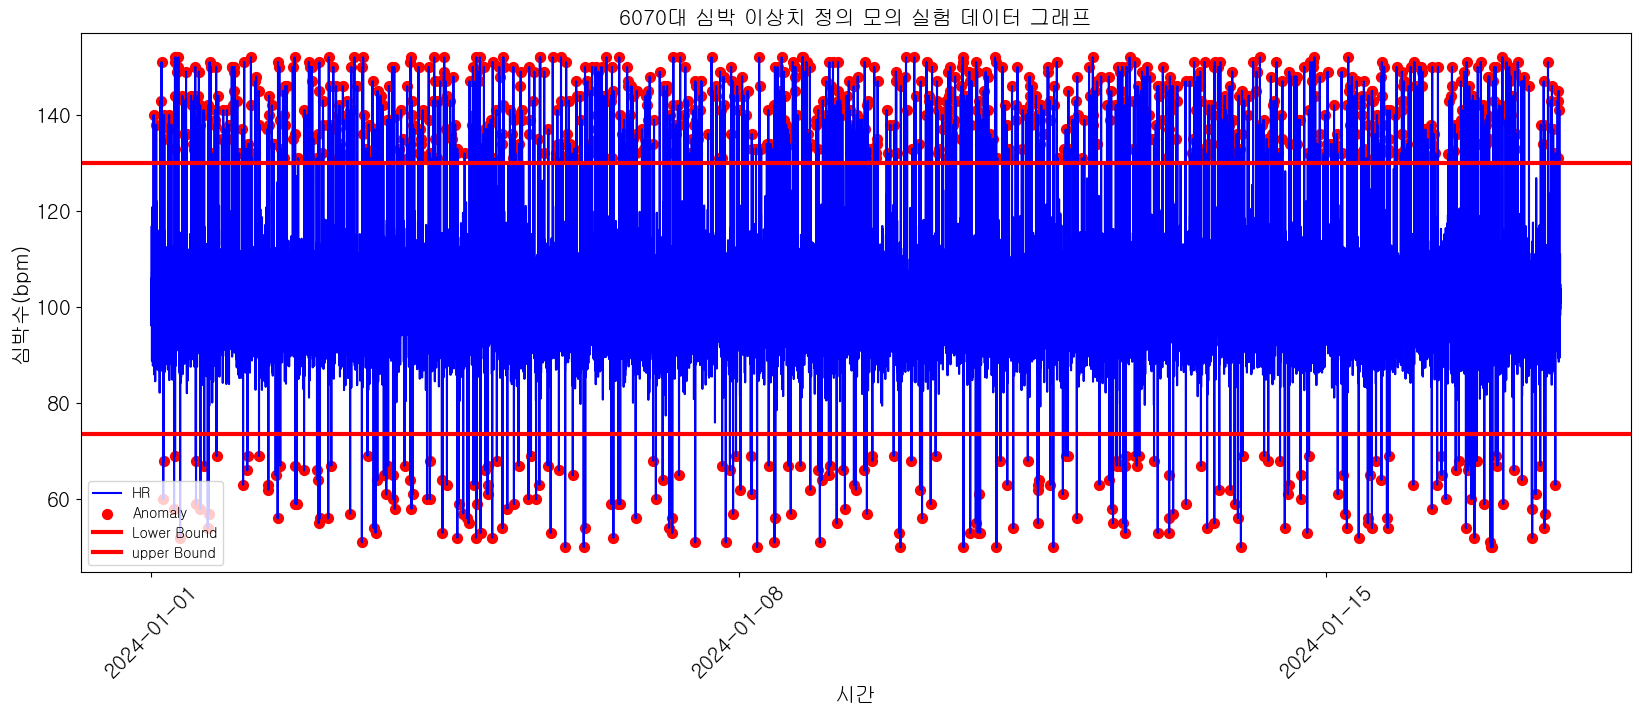

In [428]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(df_6070)), df_6070['heart_rate1'], label='HR', color='blue')

time_labels = df_6070['time'][::7*24*60]  # 7일, 24시간, 60분
anomalies = df_6070[df_6070['event1'] == 1]
plt.scatter(np.arange(len(df_6070))[df_6070['event1'] == 1], anomalies['heart_rate1'],
             color='red', label='Anomaly', s=50)

plt.title('Total Anomalies')
plt.xlabel('Time')
import matplotlib.pyplot as plt

plt.axhline(y=73.5, color='red', label='Lower Bound', linewidth=3)
plt.axhline(y=130, color='red', label='upper Bound', linewidth=3)
plt.xticks(fontsize=15)
plt.xlabel('시간', fontsize=15, fontweight='bold')
plt.xticks(ticks=time_labels.index, labels=time_labels.dt.strftime('%Y-%m-%d'), rotation=45, fontsize=15)
plt.ylabel('심박수(bpm)', fontsize=15, fontweight='bold')
plt.yticks(fontsize=15)
plt.title('6070대 심박 이상치 정의 모의 실험 데이터 그래프', fontsize=15, fontweight='bold')
plt.legend()
plt.savefig('../result/심박 6070대 이상치 그래프.png', dpi=300)

In [385]:
df_6070.to_csv('../data/로그정규/심박_6070.csv', index=False, encoding='cp949')

In [398]:
df_6070

,time,heart_rate1,heart_rate2,heart_rate3,heart_rate4,heart_rate5,heart_rate6,heart_rate7,heart_rate8,heart_rate9,...,event91,event92,event93,event94,event95,event96,event97,event98,event99,event100
0,2024-01-01 09:00:00,100.552583,90.631228,90.304552,99.148547,96.394693,100.578453,94.944473,104.926710,96.883610,...,0,0,0,0,0,1,0,0,0,0
1,2024-01-01 09:01:00,102.697944,101.353462,90.015000,93.630333,104.175350,96.465290,107.683246,96.756633,97.558345,...,0,0,0,0,0,0,0,0,0,0
2,2024-01-01 09:02:00,105.966788,103.105226,95.136219,99.650028,94.906040,85.486573,97.935089,89.539002,106.229230,...,0,0,0,0,0,0,0,0,0,0
3,2024-01-01 09:03:00,98.946174,82.444152,98.627870,96.519164,108.848514,104.848823,116.674865,114.098902,103.528565,...,0,0,0,0,0,0,0,1,0,0
4,2024-01-01 09:04:00,96.112937,89.661438,110.082731,93.199005,101.266078,106.558047,80.624270,103.903157,102.995279,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24175,2024-01-18 03:55:00,98.289858,106.205637,103.450744,91.823282,99.634461,91.777180,97.195860,100.103383,97.298556,...,0,1,0,0,0,0,0,0,0,0
24176,2024-01-18 03:56:00,104.736159,111.781232,97.785309,98.518113,114.887190,110.798886,98.038847,100.545935,95.441501,...,0,0,0,0,0,0,0,0,0,0
24177,2024-01-18 03:57:00,100.805794,100.747228,97.048787,98.956180,95.041824,91.872773,109.897787,95.828015,99.792599,...,0,0,0,0,0,0,0,0,0,0
24178,2024-01-18 03:58:00,103.835858,97.829863,116.241826,107.446824,101.593167,99.982669,140.000000,101.223549,92.106573,...,0,0,0,0,0,0,0,0,0,0
